# Loading the Model

In [1]:
import models.InceptionResNetV1_tf as Incep 
import tensorflow as tf

def load_pb_model(pb_file_path):
    with tf.io.gfile.GFile(pb_file_path, "rb") as f:
        graph_def = tf.compat.v1.GraphDef()
        graph_def.ParseFromString(f.read())
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def, name='')
    return graph

def load_weights_from_pb(pb_file_path):
    graph = load_pb_model(pb_file_path)
    with tf.compat.v1.Session(graph=graph) as sess:
        weights = {v.name: v.eval(session=sess) for v in tf.compat.v1.global_variables()}
    return weights

pb_file_path = 'models/20180402-114759.pb'
weights = load_weights_from_pb(pb_file_path)


In [2]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

input_shape = (None, 160, 160, 3)
inputs = tf.keras.Input(shape=(160, 160, 3))
net = Incep.inception_resnet_v1(inputs, is_training=True)
outputs = Dense(480, activation='softmax')(net)
facenet_model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Loading the weights into the layers
for layer in facenet_model.layers:
    if layer.name in weights:
        layer.set_weights(weights[layer.name])

for layer in facenet_model.layers:
    layer.trainable = True

# Data Augmentation

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = 'dataset/train_mtcnn_eq'

# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    validation_split=0.2,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(160, 160),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(160, 160),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

Found 26880 images belonging to 480 classes.
Found 6720 images belonging to 480 classes.


# Setting and Compiling Model

In [4]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

# Adding additional output layer for finetuning
# x = facenet_model.output
# x = Dense(1024, activation='relu')(x)
# predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# finetuned_model = Model(inputs=facenet_model.input, outputs=predictions)
facenet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Finetuning the Model

In [5]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
import json
import pandas as pd
import os
import tensorflow as tf

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
os.makedirs('finetune', exist_ok=True)
history_path = 'training_log.csv'

def append_history(history, file_name):
    history_df = pd.DataFrame(history.history)
    if os.path.isfile(file_name):
        history_df.to_csv(file_name, mode='a', header=False, index=False)
    else:
        history_df.to_csv(file_name, index=False)

ckpt_index = 'f1'
checkpoint = ModelCheckpoint(f'finetune/finetuned_model_{ckpt_index}.h5', monitor='val_loss', save_best_only=True, mode='min')
csv_logger = CSVLogger('training_log.csv', append=True)

# Print data generator details for debugging
print("Train Generator:")
for batch in train_generator:
    print("X batch shape:", batch[0].shape)
    print("y batch shape:", batch[1].shape)
    break

print("Validation Generator:")
for batch in validation_generator:
    print("X batch shape:", batch[0].shape)
    print("y batch shape:", batch[1].shape)
    break

# Train the model
try:
    history = facenet_model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        callbacks=[checkpoint, csv_logger, reduce_lr]
    )

    append_history(history, history_path)
    history_df = pd.read_csv(history_path)
    tf.saved_model.save(facenet_model, f'saved_model_{ckpt_index}')
except Exception as e:
    print("An error occurred during training:", e)


Train Generator:
X batch shape: (32, 160, 160, 3)
y batch shape: (32,)
Validation Generator:
X batch shape: (32, 160, 160, 3)
y batch shape: (32,)
Train for 840 steps, validate for 210 steps
Epoch 1/10
772/840 [==========================>...] - ETA: 2:18 - loss: 6.1792 - accuracy: 0.0023

KeyboardInterrupt: 

# Visualization

KeyError: 'accuracy'

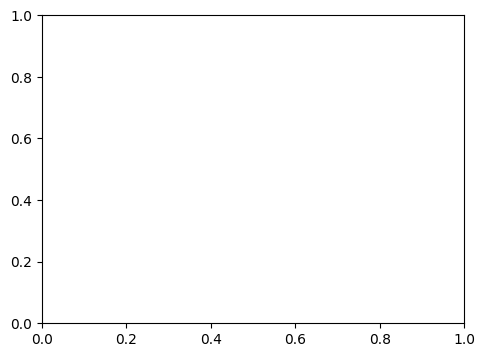

In [ ]:
history_df = pd.read_csv(history_path)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='train accuracy')
plt.plot(history_df['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='train loss')
plt.plot(history_df['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig(f'training_performance_{ckpt_index}.png')
plt.show()